['resized', '.DS_Store', 'images', 'weights', 'artists.csv']
Shape: (50, 8)
                     name  paintings  class_weight
0        Vincent van Gogh        877      0.445631
1             Edgar Degas        702      0.556721
2           Pablo Picasso        439      0.890246
3   Pierre-Auguste Renoir        336      1.163149
4          Albrecht Dürer        328      1.191519
5            Paul Gauguin        311      1.256650
6          Francisco Goya        291      1.343018
7               Rembrandt        262      1.491672
8           Alfred Sisley        259      1.508951
9                  Titian        255      1.532620
10           Marc Chagall        239      1.635223
{0: 0.44563076604125634, 1: 0.5567210567210568, 2: 0.8902464278318493, 3: 1.1631493506493507, 4: 1.1915188470066518, 5: 1.2566501023092662, 6: 1.3430178069353327, 7: 1.491672449687717, 8: 1.5089505089505089, 9: 1.532620320855615, 10: 1.6352225180677062}
Found --> input/images/images/Vincent_van_Gogh
Found --> i

/var/folders/t_/z0wbvm_s4w5_mdqm_y1smm0h0000gn/T/ipykernel_96397/4263976380.py:297: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(train_generator, verbose=1)


216/216 [==============================] - 96s 441ms/step - loss: 0.0814 - accuracy: 0.9991
Prediction accuracy on train data = 0.9991289377212524


/var/folders/t_/z0wbvm_s4w5_mdqm_y1smm0h0000gn/T/ipykernel_96397/4263976380.py:301: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(valid_generator, verbose=1)


54/54 [==============================] - 24s 441ms/step - loss: 0.4805 - accuracy: 0.8772
Prediction accuracy on CV data = 0.8771929740905762


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


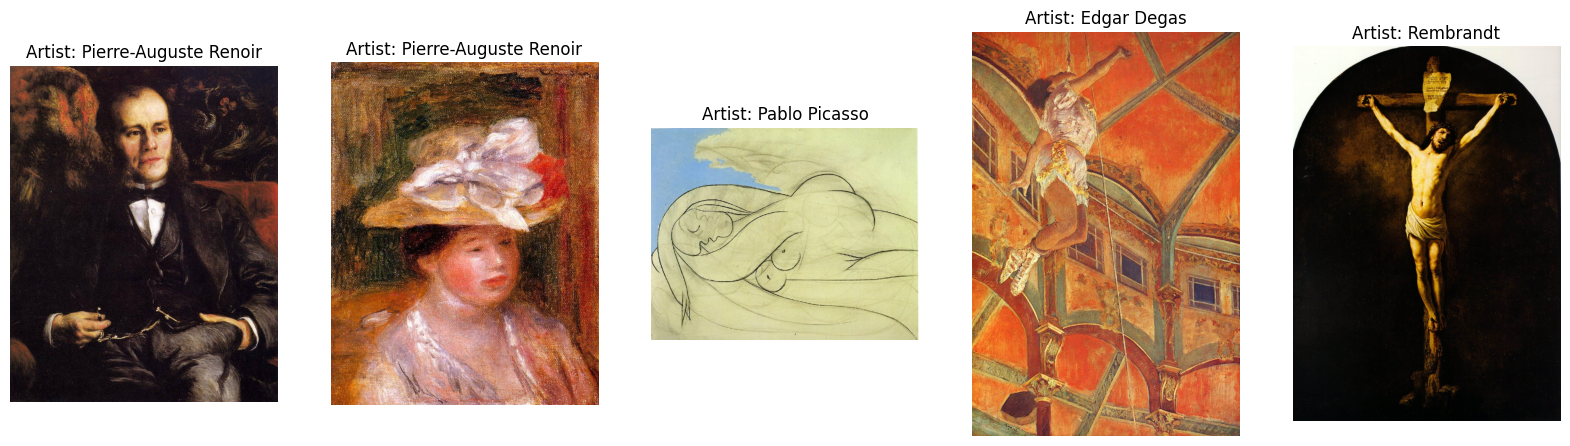

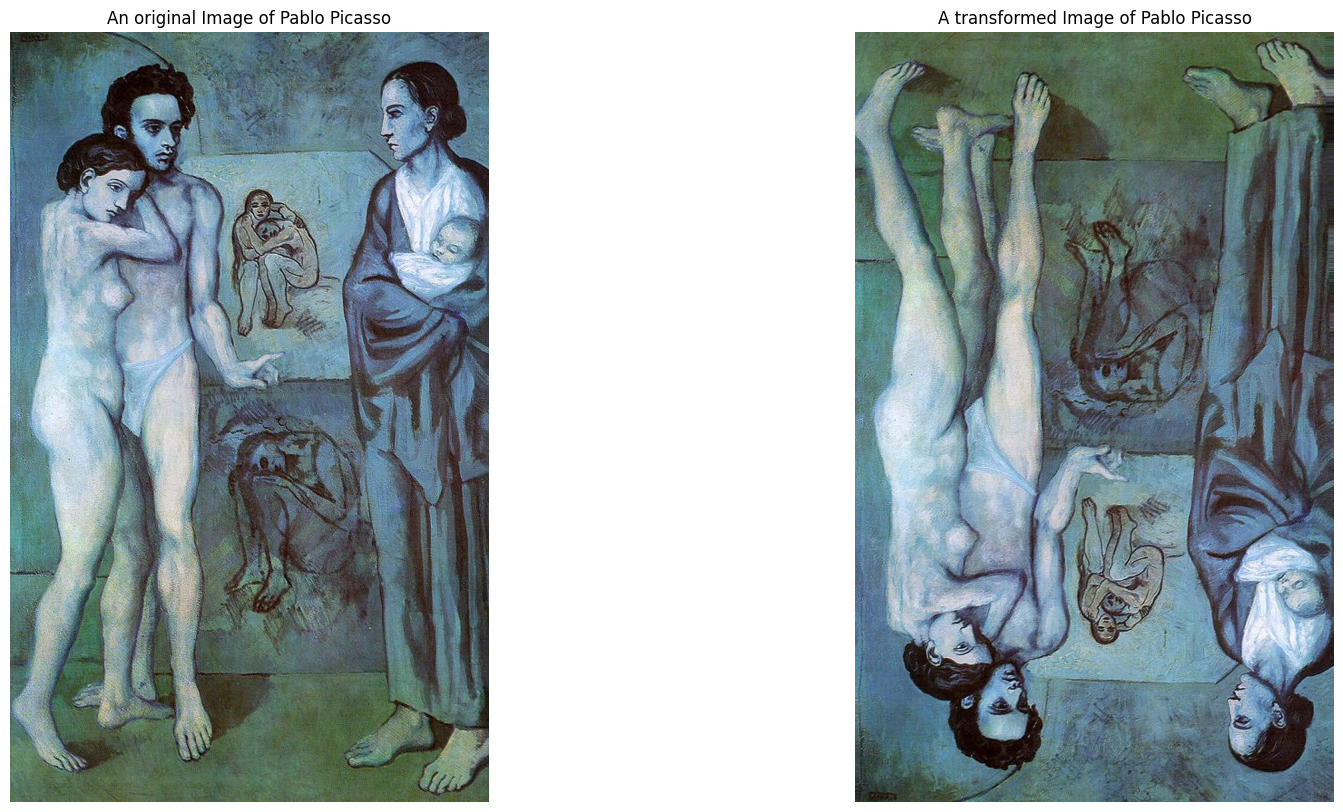

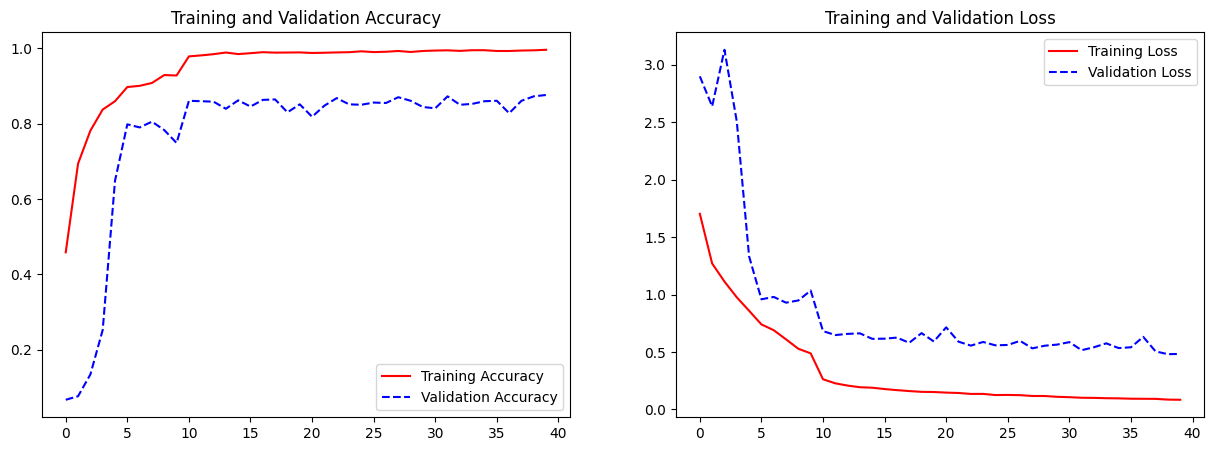

In [1]:
import concurrent.futures
import threading
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from queue import Queue
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

# Set random seeds for reproducibility
from numpy.random import seed
seed(1)
import tensorflow as tf
import imageio
import cv2
tf.random.set_seed(1)

print(os.listdir("input"))

artists = pd.read_csv('input/artists.csv')
print("Shape:", artists.shape)

# Sort artists by the number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
print(artists_top)

# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
print(class_weights)

# There is some problem recognizing 'Albrecht_Dürer' (don't know why, worth exploring)
# So I'll update this string as directory name to df's
updated_name = "Albrecht_Du╠êrer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name

# Explore images of top artists
images_dir = 'input/images/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

# Print a few random paintings
n = 5
fig, axes = plt.subplots(1, n, figsize=(20, 10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

# Augment data
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

# Print a random paintings and it's random augmented version
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
print("Original image shape:", image.shape)
aug_image = train_datagen.random_transform(image)
print("Augmented image shape:", aug_image.shape)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

# plt.show()

# Load pre-trained model
local_weights_path = 'input/weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = ResNet50(weights=local_weights_path, include_top=False, input_tensor=Input(shape=train_input_shape))
for layer in base_model.layers:
    layer.trainable = True
    
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

# Train the model - all layers
import concurrent.futures

# Function to load a batch using the generator
def load_batch(generator):
    return next(generator)

# Define the number of workers (threads) to use
num_workers = 4  # Adjust as needed

# # Create ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:

    # Training generator
    train_gen = executor.submit(load_batch, train_generator)

    # Validation generator
    valid_gen = executor.submit(load_batch, valid_generator)

    # Access the results (loaded batches)
    x_train, y_train = train_gen.result()
    x_valid, y_valid = valid_gen.result()
    
    
# Train the model - all layers
history1 = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=n_epoch,
    shuffle=True,
    verbose=1,
    callbacks=[reduce_lr],
    use_multiprocessing=False,
    workers=16,
    class_weight=class_weights
)



# Freeze core ResNet layers and train again 


for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 30
history2 = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=n_epoch,
    shuffle=True,
    verbose=1,
    callbacks=[reduce_lr, early_stop],
    use_multiprocessing=False,
    workers=16,
    class_weight=class_weights
)

# Merge history1 and history2
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']


# Update 'acc' to the correct key name
if 'acc' in history1.history:
    history['acc'] = history1.history['acc'] + history2.history['acc']
elif 'accuracy' in history1.history:
    history['acc'] = history1.history['accuracy'] + history2.history['accuracy']

history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']

# Update 'val_acc' to the correct key name
if 'val_acc' in history1.history:
    history['val_acc'] = history1.history['val_acc'] + history2.history['val_acc']
elif 'val_accuracy' in history1.history:
    history['val_acc'] = history1.history['val_accuracy'] + history2.history['val_accuracy']

history['lr'] = history1.history['lr'] + history2.history['lr']

# history = {}
# history['loss'] = history1.history['loss'] + history2.history['loss']
# history['acc'] = history1.history['acc'] + history2.history['acc']
# history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
# history['val_acc'] = history1.history['val_acc'] + history2.history['val_acc']
# history['lr'] = history1.history['lr'] + history2.history['lr']

# Plot the training graph
def plot_training(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    # plt.show()
    
plot_training(history)

# Prediction accuracy on train data
score = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

# Prediction accuracy on CV data
score = model.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on CV data =", score[1])

#save the model
model.save('./keras_model.h5')


# tick_labels = artists_top_name.tolist()

# def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
#     # Loop on each generator batch and predict
#     y_pred, y_true = [], []
#     for i in range(STEP_SIZE_VALID):
#         (X,y) = next(valid_generator)
#         y_pred.append(model.predict(X))
#         y_true.append(y)
    
#     # Create a flat list for y_true and y_pred
#     y_pred = [subresult for result in y_pred for subresult in result]
#     y_true = [subresult for result in y_true for subresult in result]
    
#     # Update Truth vector based on argmax
#     y_true = np.argmax(y_true, axis=1)
#     y_true = np.asarray(y_true).ravel()
    
#     # Update Prediction vector based on argmax
#     y_pred = np.argmax(y_pred, axis=1)
#     y_pred = np.asarray(y_pred).ravel()
    
#     # Confusion Matrix
#     fig, ax = plt.subplots(figsize=(10,10))
#     conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
#     conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
#     sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
#                 cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
#                 ax=ax)
#     ax.set_ylabel('Actual')
#     ax.set_xlabel('Predicted')
#     ax.set_title('Confusion Matrix')
#     plt.show()
    
#     print('Classification Report:')
#     print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_top_name.tolist()))

# showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

1/1 [==============================] - 0s 65ms/step


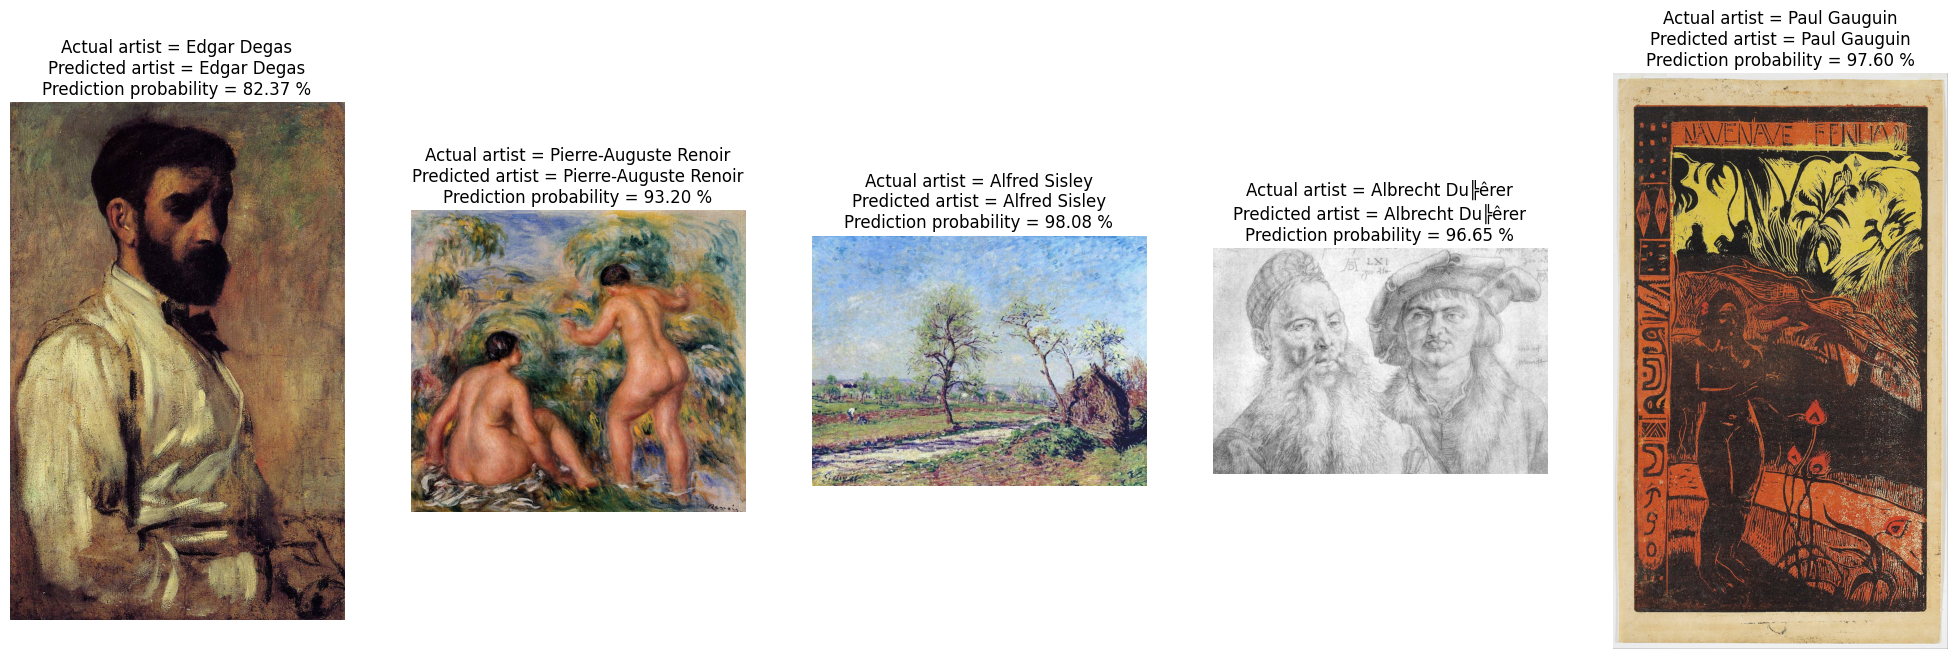

In [8]:
from keras.preprocessing import *
# Load the saved model
from keras.models import load_model

loaded_model = load_model('keras_model.h5')

model = loaded_model
n = 5
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)

    # Original image

    test_image = image.load_img(random_image_file, target_size=(train_input_shape[0:2]))

    # Predict artist
    test_image = image.img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    #print("Actual artist =", random_artist.replace('_', ' '))
    #print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
    #print("Prediction probability =", prediction_probability*100, "%")

    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    # Print image
    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

